## Backtesting

- 要記得把 slippage (滑動價差), brokerage cost 等成本算在內  
- Be conservative

### Strategy 1: Monthly Portfolio Rebalancing:

- Chose any universe of stocks (Large cap, industry specific, factor specific...) and stick to them  
- Build fixed individual position sized "long only" portfolio by picking ```m``` number of stocks based on monthly return (or other criterion)  
- Rebalance the portfolio every month by removing ```x``` stocks and replacing them with top ```x``` stocks from the universe of stocks.  (已存在於 portfolio 者若表現好，仍應納入))  
- 要考慮 ```倖存者偏差```

目標: 取 10 年間道瓊成分股作為標的，時間區間取 1 個月，參考的指標是道瓊工業指數  

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import yfinance as yf

import copy

### 1. 先載入用來判斷績效的 KPI functions，而且需要做修改，因為之前的 functions 都是 based on daily，現在要改成 monthly:

In [191]:
def CAGR(DF): # CAGR 需改變 n，並把 df['Daily Return'] 改為 df['Monthly Return']
    df = DF.copy()
    #  df['Daily Return'] = df['Adj Close'].pct_change() # first we need to calculate daily return
    df['Cumulative Return'] = (1 + df['Monthly Return']).cumprod()
    n = len(df) / 12 # there are 12 months a year
    cagr = ( (df['Cumulative Return'].tolist()[-1])**(1/n)  - 1 )
    return cagr

In [171]:
def Volatility(DF): # Volatility 需改變 vol 的算式，現在只要對 monthly return 的標準差 * 根號 "12" 即可
    df = DF.copy()
    # df['Monthly Return'] = df['Adj Close'].pct_change()
    vol = df['Monthly Return'].std() * (12 ** 0.5) # converst daily volatility to annual volatility
    return vol

In [140]:
def Sharp(DF, rf): # rf stands for "risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf) / Volatility(df)
    return sr

In [199]:
def Max_DD(DF):
    df = DF.copy()
    # df['Monthly Return'] = df['Adj Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Monthly Return']).cumprod() # 這麼多天的總報酬
    df['Cumulative Rolling Max'] = df['Cumulative Return'].cummax() # ?

    df['Draw Down'] = df['Cumulative Rolling Max'] - df['Cumulative Return']
    df['Draw Down Percentage'] = df['Draw Down'] / df['Cumulative Rolling Max']

    max_dd = df['Draw Down Percentage'].max()
    return max_dd

2. 從 yahoo finance 取得資料 (這邊用 ```0050``` 的前十大持股):

In [142]:
tickers = ['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '2002.TW', '2105.TW', '2207.TW', '2227.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2352.TW', '2357.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2609.TW', '2610.TW', '2633.TW', '2801.TW', '2880.TW']

In [143]:
len(tickers)

30

In [86]:
start = dt.datetime.today() - dt.timedelta(3650) # 10 years' data
end = dt.datetime.today()

In [87]:
ohlcv_mon = {} # create a dict to store the ohlcv data of those 10 stocks

In [88]:
for ticker in tickers: # 注意要用一個月為周期
    ohlcv_mon[ticker] = yf.download(ticker, start, end, interval='1mo')
    ohlcv_mon[ticker].dropna(inplace=True, how='all') # "all" : If all values are NA, drop that row or column.
tickers = ohlcv_mon.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [89]:
ohlcv_mon

{'1101.TW':                  Open       High        Low      Close  Adj Close  \
 Date                                                                
 2011-02-01  25.364201  28.459299  23.624701  24.976200  13.701305   
 2011-03-01  23.786501  29.288200  23.746099  28.721800  15.756045   
 2011-04-01  28.721800  36.299999  28.681400  33.940300  18.618782   
 2011-05-01  33.940300  35.765301  30.339899  35.425400  19.433468   
 2011-06-01  33.252602  34.627998  31.836700  34.627998  18.996031   
 ...               ...        ...        ...        ...        ...   
 2020-10-01  41.400002  41.650002  40.150002  40.549999  40.549999   
 2020-11-01  40.450001  43.599998  40.450001  42.900002  42.900002   
 2020-12-01  42.799999  44.049999  42.500000  43.200001  43.200001   
 2021-01-01  43.200001  43.500000  40.200001  40.349998  40.349998   
 2021-01-28  40.250000  40.599998  40.200001  40.250000  40.250000   
 
                   Volume  
 Date                      
 2011-02-01  1.430977

### 3. 將各股票的 monthly return 計算出來，並存放在另一個 data frame 中:

在這邊要用到 python 裡的 deep copy，因此要用到 ```copy``` library  
[有關 python 的複製](http://jasonyychiu.blogspot.com/2019/07/deep-copy-shallow-copy-in-python.html)

In [90]:
type(ohlcv_mon)

dict

為了保留原始資料 (即用 yfinance 下載的資料)，這邊複製一份一樣的 dictionary:

In [91]:
ohlcv_dict = copy.deepcopy(ohlcv_mon) # 暫時的，之後不會用到

In [92]:
return_df = pd.DataFrame() # 存放各股票的報酬率

In [93]:
for ticker in tickers:
    print("calculating monthly return for ", ticker)
    ohlcv_dict[ticker]["Monthly Return"] = ohlcv_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlcv_dict[ticker]["Monthly Return"]
print("All finished")

calculating monthly return for  1101.TW
calculating monthly return for  1102.TW
calculating monthly return for  1216.TW
calculating monthly return for  1301.TW
calculating monthly return for  1303.TW
calculating monthly return for  1326.TW
calculating monthly return for  1402.TW
calculating monthly return for  2002.TW
calculating monthly return for  2105.TW
calculating monthly return for  2207.TW
calculating monthly return for  2227.TW
calculating monthly return for  2303.TW
calculating monthly return for  2308.TW
calculating monthly return for  2317.TW
calculating monthly return for  2327.TW
calculating monthly return for  2330.TW
calculating monthly return for  2352.TW
calculating monthly return for  2357.TW
calculating monthly return for  2379.TW
calculating monthly return for  2382.TW
calculating monthly return for  2395.TW
calculating monthly return for  2408.TW
calculating monthly return for  2412.TW
calculating monthly return for  2454.TW
calculating monthly return for  2474.TW


In [94]:
return_df

,1101.TW,1102.TW,1216.TW,1301.TW,1303.TW,1326.TW,1402.TW,2002.TW,2105.TW,2207.TW,...,2395.TW,2408.TW,2412.TW,2454.TW,2474.TW,2609.TW,2610.TW,2633.TW,2801.TW,2880.TW
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-01,0.149967,0.107206,0.067550,0.040200,0.011669,0.103956,-0.013031,0.049253,0.142379,-0.002307,...,-0.080460,-0.031546,0.039728,0.011976,NaN,-0.083664,NaN,NaN,0.038550,-0.007961
2011-04-01,0.181691,0.158850,0.022331,0.130435,0.012687,0.035879,0.029703,0.007112,0.060118,0.038150,...,0.041758,-0.055375,-0.005459,-0.063610,NaN,0.054347,NaN,NaN,0.059320,0.040910
2011-05-01,0.043756,0.032634,0.001216,-0.059831,-0.092255,-0.051946,-0.030982,-0.031074,0.120331,0.056793,...,0.069699,-0.193104,0.027443,0.011058,NaN,0.028866,NaN,NaN,0.025441,0.039884
2011-06-01,-0.022509,0.036663,0.008482,-0.059089,-0.038896,-0.022838,-0.013229,0.008748,0.018519,0.138040,...,-0.037546,-0.307694,0.055555,-0.025000,NaN,-0.126252,NaN,NaN,-0.079418,-0.063550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,-0.020531,-0.008434,-0.019200,0.006361,-0.013445,0.016248,0.017787,-0.007335,-0.021680,-0.063764,...,-0.006873,0.005217,0.000000,0.116969,0.103850,0.185567,0.056763,-0.044234,-0.017291,-0.025496
2020-11-01,0.057953,0.052248,0.060359,0.077118,0.093697,0.119186,0.064078,0.123153,0.177285,0.064784,...,0.062284,0.252595,0.014019,0.038348,0.041551,0.152174,0.117714,0.039669,0.043988,0.055232
2020-12-01,0.006993,-0.002309,0.038462,0.131455,0.119938,0.100000,0.056569,0.085526,0.036471,0.003120,...,0.140065,0.198895,0.004608,0.061080,0.095745,1.207547,0.232106,0.007949,0.008427,0.005510


上面的兩個 ```print()``` 非常重要，因為這可以幫我們標示現在在處理哪一支股票

### 4. 正式做回測:

再說一次策略: 這個策略所有標的都是 0050 的前三十大成分股，投資組合有六個標的 (```m``` = ```6```)
每個月定期檢查，將表現 (報酬) 最差的三個標的 (```x``` = ```3```)從投資組合中刪除 (用 ```.sort_values()```)   
，並添加表現交好的標的

In [145]:
def pFlio(DF, m, x): # NOTE: DF 要放的是上面的 return_df!!!
    df = DF.copy()
    portfolio = []
    monthly_ret = [0] # the first return will always be 0 (check the return_df, the first roll will always be NaN)

    for i in range(1, len(df)): # len(df) is the total trading months
        if len(portfolio) > 0: # this if statement will not be operated in the first loop (because len(portfolio)=0)
            monthly_ret.append(df[portfolio].iloc[i, :].mean()) # count the monthly return, here we assumed the weights for all stocks are all identical

            # pick the worst 3 stocks 
            bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
            
        # add the best 3 stocks
        fill = m - len(portfolio)
        new_picks = df.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio) # always check!!!
        print(" ")
        print(len(portfolio)) # check that there's will always be 6 stocks
        

    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["Monthly Return"])
    return monthly_ret_df


若希望資產組合裡不要有重複的股票 (亦即希望每月新增的股票不在原來的 ```portfolio```，而是從 ```tickers``` 裡面選)，則可以將 ```new_picks``` 修改為:  
```python
new_picks = df[ [t for t in tickers if not in portfolio]].iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
```

In [146]:
backtest = pFlio(return_df, 6, 3)

['1101.TW', '2105.TW', '1102.TW', '1326.TW', '2330.TW', '1216.TW']
 
6
['1101.TW', '2105.TW', '1102.TW', '1101.TW', '1102.TW', '1301.TW']
 
6
['1101.TW', '2105.TW', '1101.TW', '2357.TW', '2382.TW', '2379.TW']
 
6
['2105.TW', '2382.TW', '2207.TW', '2227.TW', '2412.TW', '2382.TW']
 
6
['2105.TW', '2207.TW', '2207.TW', '1216.TW', '2395.TW', '1102.TW']
 
6
['2207.TW', '2207.TW', '1216.TW', '2454.TW', '2002.TW', '2357.TW']
 
6
['1216.TW', '2454.TW', '2002.TW', '2379.TW', '2454.TW', '2382.TW']
 
6
['1216.TW', '2002.TW', '2382.TW', '1402.TW', '2317.TW', '2303.TW']
 
6
['1216.TW', '2382.TW', '2303.TW', '2207.TW', '2227.TW', '2330.TW']
 
6
['1216.TW', '2382.TW', '2227.TW', '2227.TW', '1303.TW', '2382.TW']
 
6
['2227.TW', '2227.TW', '1303.TW', '2227.TW', '2379.TW', '2303.TW']
 
6
['2227.TW', '2227.TW', '2227.TW', '2408.TW', '2609.TW', '2207.TW']
 
6
['2207.TW', '2207.TW', '2317.TW', '2382.TW', '2330.TW', '2395.TW']
 
6
['2382.TW', '2330.TW', '2395.TW', '2379.TW', '1216.TW', '2357.TW']
 
6
['2382

In [147]:
len(backtest)

120

In [148]:
backtest

,Monthly Return
0,0.000000
1,0.082616
2,0.035547
3,-0.028394
4,0.079387
...,...
115,0.033839
116,0.141054
117,0.366445
118,-0.106157


### 4. 計算此策略的 KPIs:

In [149]:
type(backtest)

pandas.core.frame.DataFrame

In [204]:
cagr = CAGR(backtest)
vol = Volatility(backtest)
sr = Sharp(backtest, 0.022) # Assume risk free rate = 2.2%
dd = Max_DD(backtest)

In [205]:
cagr

0.21165637894949008

In [206]:
vol

0.25517520529346055

In [207]:
sr # not bad

0.7432398407650089

In [208]:
dd

0.2770096774602763

以下將 ```new_picks``` 修改為選擇不重複的股票:

In [210]:
def pFlio(DF, m, x): # NOTE: DF 要放的是上面的 return_df!!!
    df = DF.copy()
    portfolio = []
    monthly_ret = [0] # the first return will always be 0 (check the return_df, the first roll will always be NaN)

    for i in range(1, len(df)): # len(df) is the total trading months
        if len(portfolio) > 0: # this if statement will not be operated in the first loop (because len(portfolio)=0)
            monthly_ret.append(df[portfolio].iloc[i, :].mean()) # count the monthly return, here we assumed the weights for all stocks are all identical

            # pick the worst 3 stocks 
            bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
            
        # add the best 3 stocks
        fill = m - len(portfolio)
        new_picks = df[ [t for t in tickers if t not in portfolio]].iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio) # always check!!!
        print(" ")
        print(len(portfolio)) # check that there's will always be 6 stocks
        

    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["Monthly Return"])
    return monthly_ret_df

In [213]:
backtest2 = pFlio(return_df, 6, 3)

['1101.TW', '2105.TW', '1102.TW', '1326.TW', '2330.TW', '1216.TW']
 
6
['1101.TW', '2105.TW', '1102.TW', '1301.TW', '2379.TW', '2227.TW']
 
6
['1101.TW', '2105.TW', '2379.TW', '2357.TW', '2382.TW', '2395.TW']
 
6
['1101.TW', '2105.TW', '2382.TW', '2207.TW', '2227.TW', '2412.TW']
 
6
['1101.TW', '2105.TW', '2207.TW', '1216.TW', '2395.TW', '1102.TW']
 
6
['2105.TW', '2207.TW', '1216.TW', '2454.TW', '2002.TW', '2357.TW']
 
6
['2105.TW', '1216.TW', '2454.TW', '2379.TW', '2382.TW', '2352.TW']
 
6
['2105.TW', '1216.TW', '2352.TW', '1402.TW', '2317.TW', '2303.TW']
 
6
['1216.TW', '2317.TW', '2303.TW', '2207.TW', '2227.TW', '2330.TW']
 
6
['1216.TW', '2317.TW', '2227.TW', '1303.TW', '2382.TW', '1101.TW']
 
6
['2317.TW', '2227.TW', '1101.TW', '2379.TW', '2303.TW', '2352.TW']
 
6
['2227.TW', '2379.TW', '2352.TW', '2408.TW', '2609.TW', '2207.TW']
 
6
['2227.TW', '2609.TW', '2207.TW', '2317.TW', '2382.TW', '2330.TW']
 
6
['2227.TW', '2382.TW', '2330.TW', '2379.TW', '1216.TW', '2357.TW']
 
6
['2227

In [214]:
cagr = CAGR(backtest2)
vol = Volatility(backtest2)
sr = Sharp(backtest2, 0.022) # Assume risk free rate = 2.2%
dd = Max_DD(backtest2)

In [215]:
sr

0.7252184658515245

In [217]:
vol

0.2183952301029262

注意到跟允許重複股票的策略相比，不重複股票投資組合的 Sharp ratio 較低，vol 較高  
這是合理的，因為不能重複股票的話，就不能再選報酬好的那些股票，因此 sharp ratio 會較低

### 5. 跟台灣加權指數相比:

In [226]:
ticker = ['^TWII']
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()

In [227]:
twii = yf.download(ticker, start, end, interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [228]:
twii

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-02-01,9220.690430,9220.690430,8470.089844,8599.650391,8599.618164,47511600
2011-03-01,8611.790039,8829.230469,8070.520020,8683.299805,8683.267578,63751400
2011-04-01,8697.839844,9099.750000,8592.230469,9007.870117,9007.836914,50125800
2011-05-01,9014.330078,9082.009766,8673.379883,8988.839844,8988.806641,48941200
2011-06-01,8999.839844,9089.469727,8433.459961,8652.589844,8652.557617,43685800
...,...,...,...,...,...,...
2020-10-01,12567.879883,12997.790039,12519.120117,12546.339844,12546.339844,65701900
2020-11-01,12565.320312,13969.389648,12480.660156,13722.889648,13722.889648,88068200
2020-12-01,13810.549805,14760.059570,13749.709961,14732.530273,14732.530273,142922300


In [229]:
twii['Monthly Return'] = twii['Adj Close'].pct_change()

In [230]:
cagr = CAGR(twii)
vol = Volatility(twii)
sr = Sharp(twii, 0.022) # Assume risk free rate = 2.2%
dd = Max_DD(twii)

In [231]:
sr

0.2663951912473093

In [232]:
dd

0.23354582191613743

### 6. Visualization:

In [237]:
backtest

,Monthly Return,Cumulative Return
0,0.000000,1.000000
1,0.082616,1.082616
2,0.035547,1.121100
3,-0.028394,1.089267
4,0.079387,1.175740
...,...,...
115,0.033839,4.968526
116,0.141054,5.669356
117,0.366445,7.746860
118,-0.106157,6.924474


In [283]:
twii.reset_index(drop=True, inplace=True)

In [284]:
twii.index

RangeIndex(start=0, stop=121, step=1)

In [285]:
twii["Monthly Return"][1:]

1      0.009727
2      0.037379
3     -0.002113
4     -0.037408
5     -0.000972
         ...   
116    0.002455
117    0.093776
118    0.073573
119    0.065767
120   -0.018188
Name: Monthly Return, Length: 120, dtype: float64

```.reset_index()``` 將 ```data frame``` 的 index 改為數字形式

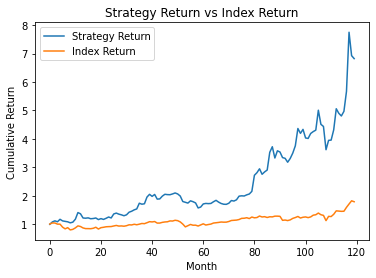

In [288]:
fig, ax = plt.subplots()
plt.plot( backtest['Cumulative Return'] )
plt.plot( (1+twii["Monthly Return"][1:].reset_index(drop=True)).cumprod() )

plt.title("Strategy Return vs Index Return")
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
ax.legend( ["Strategy Return", "Index Return" ])
